## AI Interior Design

### Importing Requirements

In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
import accelerate
import xformers
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionPipeline

c:\Users\conta\Documents\jupyter\AI-Models\nothing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.1+cu121 with CUDA 1201 (you have 2.2.1+cu118)
    Python  3.11.8 (you have 3.11.8)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\conta\Documents\jupyter\AI-Models\nothing\venv\Lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # n

### Set The GPU Device (Nvidia)

In [2]:
torch.cuda.set_device(0)

### Image To Image Model

In [3]:
image_pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


### Text To Image Model

In [4]:
text_pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


### Implement the attention mechanism slicing (reduces the memory usage of self-attention)

In [5]:
image_pipe.enable_attention_slicing()
text_pipe.enable_attention_slicing()

### load of cpu to gpu transfer

In [6]:
image_pipe.enable_sequential_cpu_offload()
text_pipe.enable_sequential_cpu_offload()

### Use the xformers for memory efficiency (optional method to accelerate image generation)

In [7]:
image_pipe.enable_xformers_memory_efficient_attention()
text_pipe.enable_xformers_memory_efficient_attention()

NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(1, 2, 1, 40) (torch.float32)
     key         : shape=(1, 2, 1, 40) (torch.float32)
     value       : shape=(1, 2, 1, 40) (torch.float32)
     attn_bias   : <class 'NoneType'>
     p           : 0.0
`decoderF` is not supported because:
    xFormers wasn't build with CUDA support
    attn_bias type is <class 'NoneType'>
    operator wasn't built - see `python -m xformers.info` for more info
`flshattF@0.0.0` is not supported because:
    xFormers wasn't build with CUDA support
    dtype=torch.float32 (supported: {torch.bfloat16, torch.float16})
    operator wasn't built - see `python -m xformers.info` for more info
`cutlassF` is not supported because:
    xFormers wasn't build with CUDA support
    operator wasn't built - see `python -m xformers.info` for more info
`smallkF` is not supported because:
    max(query.shape[-1] != value.shape[-1]) > 32
    xFormers wasn't build with CUDA support
    operator wasn't built - see `python -m xformers.info` for more info
    unsupported embed per head: 40

### Manages the state of the algorithm

In [8]:
generator = torch.Generator("cuda").manual_seed(0)

## Testing Purpose

### Test Image

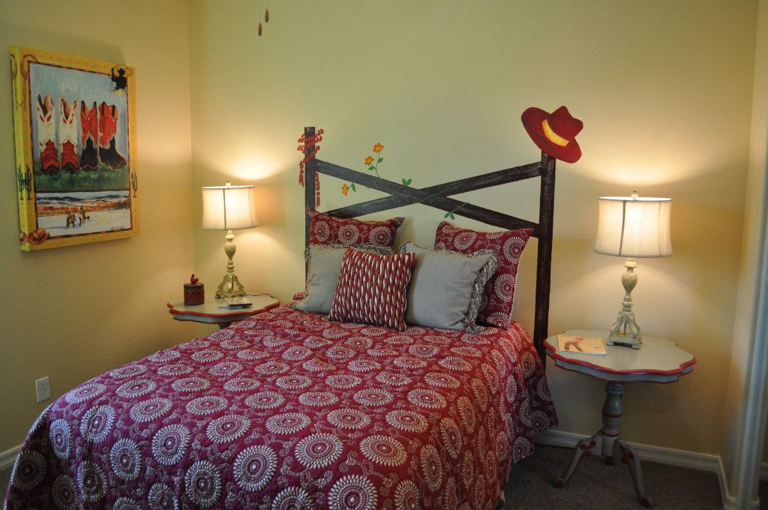

In [9]:
# URL of the initial image
url = "https://i.pinimg.com/originals/9d/dc/a2/9ddca29b74fe20aac551ccf838f2b89e.jpg"

# Download the image and convert it to RGB format
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")

# Resize the image to a maximum of 768x768 pixels
init_image.thumbnail((768, 768))


init_image.save("runwayml-stable-diffusion-v1-5-row.jpg")

# Display the initial image (optional)
init_image

### Prompt

In [10]:
prompt = "minimalist interior design (((guest room))) with full furnitures: TV, guest room Couch, table, lamp, Wall art, pillow, Natural Lighting, Incandescent lamps, Optical Fiber, Capricious Lighting, Ray Tracing Reflections, (((pink and white color))) --ar 16:9 --v 5.2"

### Negative Prompt

In [11]:
negative_prompt = "(((Ugly))), low-resolution, morbid, blurry, cropped, deformed, dehydrated, text, disfigured, duplicate, error, extra arms, extra fingers, extra legs, extra limbs, fused fingers, gross proportions, jpeg artifacts, long neck, low resolution, tiling, poorly drawn feet, extra limbs, disfigured, body out of frame, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face, low quality, lowres, low saturation, deformed body features, watermark, water mark"

### Generate Image using Prompt + Image

In [12]:
image_to_image_output = image_pipe(prompt, init_image, generator=generator , strength=0.7, num_images_per_prompt=1 ,  guidance_scale=10, negative_prompt=negative_prompt).images

c:\Users\conta\Documents\jupyter\AI-Models\nothing\venv\Lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 35/35 [00:37<00:00,  1.08s/it]


#### Prompt + Image Output

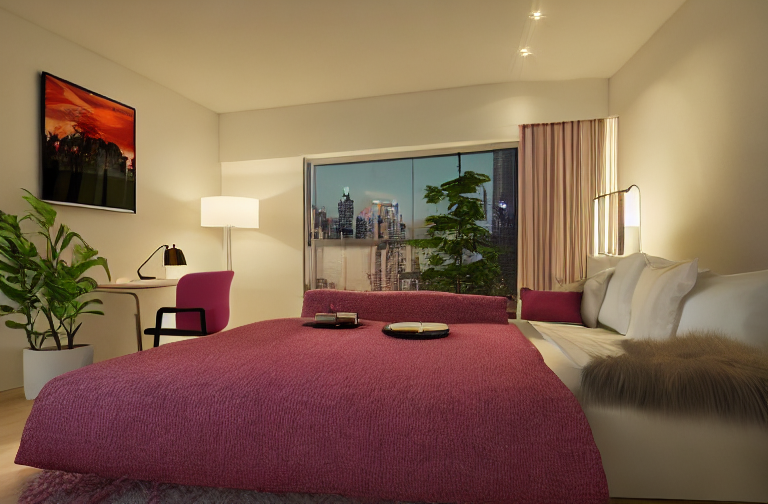

In [13]:
image_to_image_output[0]

### Generate Image using Prompt

In [14]:
text_to_image_output = text_pipe(prompt, generator=generator , num_images_per_prompt=1 ,  guidance_scale=10, negative_prompt=negative_prompt).images

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


#### Prompt Output

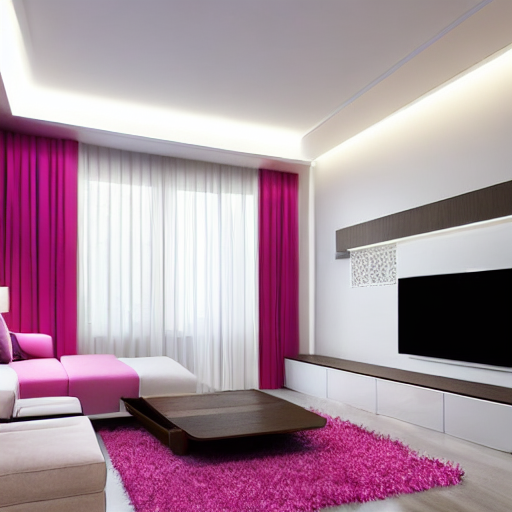

In [15]:
text_to_image_output[0]

### Save The Image

In [26]:
image_to_image_output[0].save("Prompt-and-Image-Output.jpg")
text_to_image_output[0].save("Image-Output.jpg")

### Empty the Catch

In [27]:
torch.cuda.empty_cache()

### Delete The Pipeline

del image_pipe
del text_pipe

### Website Routes

In [28]:
from flask import Flask, request, app, jsonify, url_for, render_template, send_file
from flask_cors import CORS
import time
import base64

In [29]:
app=Flask(__name__)
CORS(app)

In [30]:
@app.route('/predict', methods=['POST'])
def predict():
    prompt = request.form.get('prompt')
    negativeprompt = request.form.get('negativeprompt')
  
    output_img = text_pipe(prompt=prompt, generator=generator , num_images_per_prompt=1 ,  guidance_scale=10, negative_prompt=negativeprompt).images
    time.sleep(1)
    torch.cuda.empty_cache()
    
    buffer = BytesIO()
    output_img[0].save(buffer, 'png')
    buffer.seek(0)
    
    data = buffer.read()
    data = base64.b64encode(data).decode()
    time.sleep(1)
    return f'"data:image/png;base64,{data}"'

In [31]:
@app.route('/predict2', methods=['POST'])
def predict2():
    roomType = request.form.get('roomType')
    typeDesign = request.form.get('typeDesign')
    text = request.form.get('text') 

    if 'image' in request.files:
        image_file = request.files['image']
        init_image = Image.open(image_file).convert("RGB")
        init_image.thumbnail((768, 768))
        prompt = ""

        if (roomType=="livingRoom"):
            prompt = "{typeDesign} interior design living room with sofa, coffee table, armchairs, TV stand, bookshelves, rug, curtains, floor lamps, Wall art, Accent Lighting, Smart Lighting, Fireplace --ar 16:9 --v 5.2 and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        elif (roomType=="classRoom"):
            prompt = "{typeDesign} interior design with desks, benches, whiteboard, teacher, principal, student, projector,educational posters,lighting, dimmable lights, and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        elif (roomType=="diningRoom"):
            prompt = "{typeDesign}  interior design dining room with dining table, chairs, sideboard, chandelier, rug, curtains, wall shelves, Wall art, Natural Lighting, Dimmable Lights, Pendants --ar 16:9 --v 5.2 and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        elif (roomType=="bathroom"):
            prompt = "{typeDesign} interior design bathroom with bathtub, shower, sink, toilet, mirror, storage cabinets, tiles, Ambient Lighting, Task Lighting, LED strips --ar 16:9 --v 5.2 and other requirements  are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        elif (roomType=="bedroom"):
            prompt = "{typeDesign} interior design bedroom with bed, nightstands, dresser, wardrobe, rug, curtains, bedside lamps, Wall art, Cozy Lighting, Dimmable Lights, Ceiling Fan --ar 16:9 --v 5.2 and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        else:
            prompt = "{typeDesign} interior design {roomType} with full furnitures, window, guest room Couch, table, lamp, Wall art, Natural Lighting, Incandescent lamps, Optical Fiber --ar 16:9 --v 5.2 and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
        
        negative_prompt = "(((Ugly))), low-resolution, morbid, blurry, cropped, deformed, dehydrated, text, disfigured, duplicate, error, extra arms, extra fingers, extra legs, extra limbs, fused fingers, gross proportions, jpeg artifacts, long neck, low resolution, tiling, poorly drawn feet, extra limbs, disfigured, body out of frame, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face, low quality, lowres, low saturation, deformed body features, watermark, water mark"
        output_img = image_pipe(prompt, init_image, generator=generator , strength=0.7, num_images_per_prompt=1 ,  guidance_scale=10, negative_prompt=negative_prompt).images
        time.sleep(1)
        torch.cuda.empty_cache()

        buffer = BytesIO()
        output_img[0].save(buffer, 'png')
        buffer.seek(0)
    
        data = buffer.read()
        data = base64.b64encode(data).decode()
        time.sleep(1)
        return f'"data:image/png;base64,{data}"'

In [32]:
# @app.route('/predict2', methods=['POST'])
# def predict2():
#     roomType = request.form.get('roomType')
#     typeDesign = request.form.get('typeDesign')
#     text = request.form.get('text') 

#     if 'image' in request.files:
#         image_file = request.files['image']
#         init_image = Image.open(image_file).convert("RGB")
#         init_image.thumbnail((768, 768))
        
#         prompt = "{typeDesign} interior design {roomType} with full furnitures, window, guest room Couch, table, lamp, Wall art, Natural Lighting, Incandescent lamps, Optical Fiber --ar 16:9 --v 5.2 and other requirements are {text}".format(roomType=roomType, typeDesign=typeDesign, text=text)
#         print(prompt)
#         negative_prompt = "(((Ugly))), low-resolution, morbid, blurry, cropped, deformed, dehydrated, text, disfigured, duplicate, error, extra arms, extra fingers, extra legs, extra limbs, fused fingers, gross proportions, jpeg artifacts, long neck, low resolution, tiling, poorly drawn feet, extra limbs, disfigured, body out of frame, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face, low quality, lowres, low saturation, deformed body features, watermark, water mark"
#         output_img = image_pipe(prompt, init_image, generator=generator , strength=0.7, num_images_per_prompt=1 ,  guidance_scale=10, negative_prompt=negative_prompt).images
#         time.sleep(1)
#         torch.cuda.empty_cache()

#         buffer = io.BytesIO()
#         output_img[0].save(buffer, 'png')
#         buffer.seek(0)
    
#         data = buffer.read()
#         data = base64.b64encode(data).decode()
#         time.sleep(1)
#         return f'"data:image/png;base64,{data}"'

In [33]:
if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
